# Validating Strawberry Puree via Infrared Spectral Analysis

<br>
<br>

The purpose of this analysis is to classify strawberry puree as "pure" or "not-pure" by analyzing the frequency domain in the mid-infrared spectrum using Attenuated Total Reflectance sampling.  Not-pure samples have been adulterated with other fruit purees.  

Spectral analysis is a common practice in analyzing fruit and vegetables.  Here, we use a back prop network with 5 hidden layers.

<br>
<br>

~~The Input Layer is made up of 235 nodes.  Each input node represents the strength of a specific wavenumber

~~Hidden Layers 1 and 5 have 1000 ReLU nodes

~~Hidden Layers 2,3 and 4 have 10000

~~The Output Layer is made up of 2 nodes representing unadulerated strawberry puree or the adulterated version.

<br>
<br>
<br>

The data used in this notebook came from an original analysis by Holland, Kemsley and Wilson.

<i>"Use of Fourier transform infrared spectroscopy and partial least squares regression for the detection of adulteration of strawberry purees" Holland JK, Kemsley EK, Wilson RH. (1998). Journal of the Science of Food and Agriculture, 76, 263-269</i>

Abstract and Full-text (paywall) are available here: https://europepmc.org/article/agr/ind21806286

The dataset was downloaded from: http://www.timeseriesclassification.com/description.php?Dataset=Strawberry

<br>
<br>
<br>


## Side note:

I deliberately threw the bus at the problem.  There is no need  for so many dense layers.  There is no need to 80 epochs of training.  This was just a feasibility study and needs to be cleaned up.

<br>
<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

plt.style.use('dark_background')


In [2]:
import torch
print('CUDA available: '.ljust(25), torch.cuda.is_available())
print('CUDA device count: '.ljust(25), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device num: '.ljust(25), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(25), torch.cuda.get_device_name(current_device))


CUDA available:           True
CUDA device count:        1
Current CUDA Device num:  0
Current CUDA Device:      GeForce RTX 2070 SUPER


In [3]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
df = pd.read_csv('MIR_Fruit_purees.csv')
df.head()

,Wavenumbers,NON-Strawberry,NON-Strawberry.1,NON-Strawberry.2,NON-Strawberry.3,NON-Strawberry.4,NON-Strawberry.5,NON-Strawberry.6,NON-Strawberry.7,NON-Strawberry.8,...,NON-Strawberry.622,NON-Strawberry.623,NON-Strawberry.624,NON-Strawberry.625,NON-Strawberry.626,NON-Strawberry.627,NON-Strawberry.628,NON-Strawberry.629,NON-Strawberry.630,NON-Strawberry.631
0,899.327,0.002806,0.002637,0.002416,0.002345,0.002303,0.002514,0.002105,0.002018,0.002154,...,0.002539,0.002569,0.002723,0.002542,0.002627,0.002631,0.002730,0.002713,0.002697,0.002789
1,903.187,0.002732,0.002638,0.002480,0.002292,0.002342,0.002488,0.002078,0.001999,0.002165,...,0.002507,0.002569,0.002714,0.002539,0.002629,0.002651,0.002839,0.002779,0.002905,0.003040
2,907.047,0.002661,0.002651,0.002511,0.002249,0.002350,0.002477,0.002077,0.001945,0.002191,...,0.002483,0.002541,0.002740,0.002574,0.002619,0.002696,0.002999,0.002877,0.003277,0.003359
3,910.907,0.002657,0.002757,0.002611,0.002303,0.002419,0.002542,0.002154,0.001964,0.002275,...,0.002563,0.002599,0.002861,0.002664,0.002714,0.002809,0.003259,0.003085,0.003711,0.003796
4,914.767,0.002699,0.003000,0.002802,0.002466,0.002561,0.002713,0.002311,0.002083,0.002470,...,0.002764,0.002806,0.003090,0.002829,0.002939,0.003022,0.003649,0.003419,0.004265,0.004394


<br>
<br>

# Data Wrangling

### Isolate Wavenumbers from the dataframe

In [5]:
# isolate the wavenumbers into a new variable
wavenumbers = df.iloc[:,0]

In [6]:
# remove "Wavenumbers" from the original df prior to Transposing
df.drop(labels='Wavenumbers', axis=1, inplace=True)

<br>

### Transpose the dataframe, and rename the output variable

In [7]:
# Transpose the df and reset index, then rename the old index
df = df.T
df = df.reset_index()
df = df.rename(columns={'index': 'Outcome'})

# shuffle the df so Outcome is at the end 
df = df.iloc[:,1:].join(df.iloc[:,0])

<br>

### Rename the Columns as Wavenumbers

In [8]:
# convert the wavenumbers to columns and round them down to 3 decimal places
cols = [ round(f, 3) for f in wavenumbers.to_list() ]

# add the final column name 'Outcome' to the list and set the df columns 
cols.append('Outcome')
df.columns = cols

# sort the df by Outcome and reset index
df = df.sort_values('Outcome').reset_index(drop=True)

df

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
0,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009,NON-Strawberry
1,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005,NON-Strawberry.1
2,0.002054,0.002039,0.002030,0.002076,0.002202,0.002350,0.002408,0.002352,0.002276,0.002273,...,0.000466,0.000294,0.000192,0.000125,0.000077,0.000054,0.000035,0.000014,0.000014,NON-Strawberry.10
3,0.002330,0.002332,0.002291,0.002328,0.002482,0.002639,0.002655,0.002555,0.002467,0.002428,...,0.000337,0.000219,0.000111,0.000071,0.000024,0.000052,0.000061,0.000018,0.000018,NON-Strawberry.100
4,0.002562,0.002565,0.002584,0.002691,0.002886,0.003113,0.003233,0.003239,0.003178,0.003077,...,0.000307,0.000199,0.000126,0.000082,0.000051,0.000041,0.000029,0.000009,0.000009,NON-Strawberry.101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.002123,0.002187,0.002206,0.002206,0.002351,0.002564,0.002668,0.002598,0.002560,0.002507,...,0.000254,0.000151,0.000096,0.000066,0.000043,0.000038,0.000037,0.000014,0.000014,Strawberry.95
979,0.002384,0.002392,0.002383,0.002491,0.002710,0.002888,0.002948,0.002914,0.002822,0.002701,...,0.000103,0.000054,0.000021,0.000012,0.000005,0.000015,0.000026,0.000013,0.000013,Strawberry.96
980,0.002449,0.002499,0.002506,0.002657,0.002912,0.003137,0.003310,0.003324,0.003217,0.003085,...,0.000103,0.000057,0.000035,0.000020,0.000016,0.000015,0.000009,0.000007,0.000007,Strawberry.97
981,0.002276,0.002358,0.002431,0.002593,0.002830,0.003089,0.003257,0.003285,0.003238,0.003143,...,0.000184,0.000102,0.000060,0.000032,0.000023,0.000019,0.000014,0.000013,0.000013,Strawberry.98


<br>
<br>

### Convert the Dependent Variable to True or False values

Binary classification problem

In [9]:
# replace NON Strawberry outcomes with False
df.loc[:, 'Outcome'] = df.loc[:,'Outcome'].replace(to_replace=r'^NON.*$', value=False, regex=True)

# replace Strawberry with True
df.loc[:, 'Outcome'] = df.loc[:,'Outcome'].replace(to_replace=r'^Straw.*$', value=True, regex=True)

In [10]:
df

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
0,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009,False
1,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005,False
2,0.002054,0.002039,0.002030,0.002076,0.002202,0.002350,0.002408,0.002352,0.002276,0.002273,...,0.000466,0.000294,0.000192,0.000125,0.000077,0.000054,0.000035,0.000014,0.000014,False
3,0.002330,0.002332,0.002291,0.002328,0.002482,0.002639,0.002655,0.002555,0.002467,0.002428,...,0.000337,0.000219,0.000111,0.000071,0.000024,0.000052,0.000061,0.000018,0.000018,False
4,0.002562,0.002565,0.002584,0.002691,0.002886,0.003113,0.003233,0.003239,0.003178,0.003077,...,0.000307,0.000199,0.000126,0.000082,0.000051,0.000041,0.000029,0.000009,0.000009,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.002123,0.002187,0.002206,0.002206,0.002351,0.002564,0.002668,0.002598,0.002560,0.002507,...,0.000254,0.000151,0.000096,0.000066,0.000043,0.000038,0.000037,0.000014,0.000014,True
979,0.002384,0.002392,0.002383,0.002491,0.002710,0.002888,0.002948,0.002914,0.002822,0.002701,...,0.000103,0.000054,0.000021,0.000012,0.000005,0.000015,0.000026,0.000013,0.000013,True
980,0.002449,0.002499,0.002506,0.002657,0.002912,0.003137,0.003310,0.003324,0.003217,0.003085,...,0.000103,0.000057,0.000035,0.000020,0.000016,0.000015,0.000009,0.000007,0.000007,True
981,0.002276,0.002358,0.002431,0.002593,0.002830,0.003089,0.003257,0.003285,0.003238,0.003143,...,0.000184,0.000102,0.000060,0.000032,0.000023,0.000019,0.000014,0.000013,0.000013,True


<br>
<br>
<br>

# EDA on the Spectra

### Plot wavenumbers for Strawberry == True

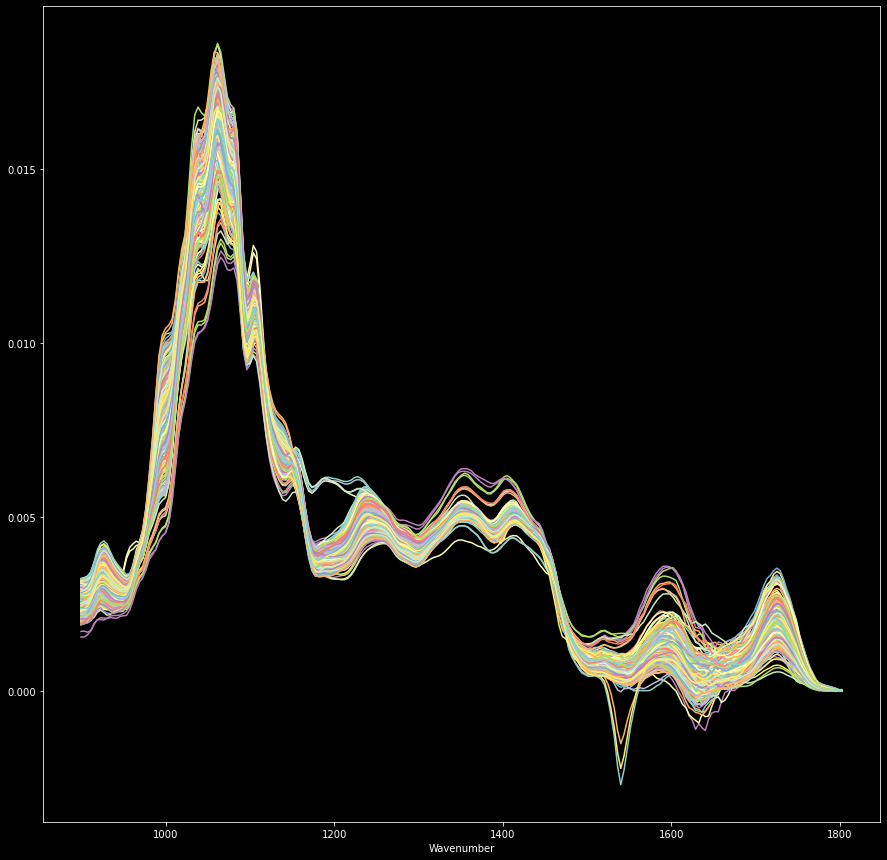

In [11]:
# plot wavenumber vs emission where Strawberry == True
plt.figure(figsize=(15,15))
plt.plot(df.query('Outcome == True').loc[:,df.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>
<br>

### Plot wavenumbers for Strawberry == False

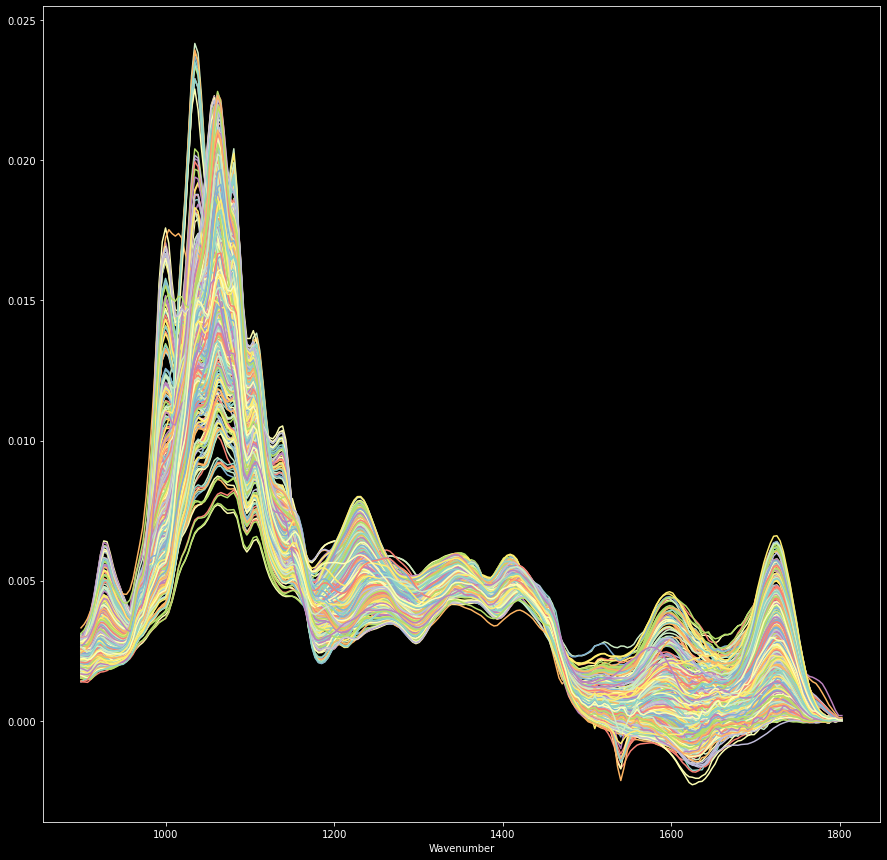

In [12]:
# plot the wavenumber vs emission where Strawberry == False
plt.figure(figsize=(15,15))
plt.plot(df.query('Outcome == False').loc[:,df.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>
<br>

### Split the Data into Training and Validation Sets

In [13]:
# subset 30% of the dataframe to make up the validation set
dfv = df.sample(frac=0.3, replace=False, random_state=4)

# assign the rest as the training set
dft = df.drop(dfv.index)

In [14]:
# Shuffle
dft = dft.sample(len(dft))
dfv = dfv.sample(len(dfv))

In [15]:
dfv

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
237,0.002759,0.002843,0.002991,0.003210,0.003521,0.003902,0.004268,0.004471,0.004429,0.004212,...,0.000061,3.686320e-05,0.000028,0.000020,0.000020,7.240290e-06,-2.105050e-06,3.755280e-07,3.755280e-07,False
665,0.002631,0.002710,0.002803,0.002959,0.003228,0.003571,0.003825,0.003901,0.003829,0.003677,...,0.000173,1.090020e-04,0.000070,0.000045,0.000030,1.763030e-05,1.114430e-05,5.783370e-06,5.783370e-06,True
337,0.002714,0.002635,0.002555,0.002525,0.002583,0.002639,0.002528,0.002350,0.002216,0.002109,...,0.000081,4.318410e-05,0.000027,0.000013,0.000001,-2.906060e-06,2.112930e-07,2.374220e-06,0.000000e+00,False
11,0.002691,0.002670,0.002727,0.002891,0.003119,0.003390,0.003545,0.003541,0.003450,0.003296,...,0.000290,1.857720e-04,0.000018,0.000007,-0.000047,4.783590e-05,9.852540e-05,1.700360e-05,1.700360e-05,False
646,0.002404,0.002398,0.002409,0.002521,0.002737,0.002956,0.003066,0.003046,0.002999,0.002907,...,0.000154,9.094720e-05,0.000059,0.000035,0.000020,1.215170e-05,7.267570e-06,5.603150e-06,5.603150e-06,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,0.002675,0.002737,0.002838,0.003008,0.003291,0.003631,0.003880,0.003971,0.003906,0.003732,...,0.000149,9.311680e-05,0.000056,0.000036,0.000025,1.352150e-05,7.293050e-06,2.868930e-06,2.868930e-06,True
712,0.003038,0.003026,0.003044,0.003126,0.003329,0.003553,0.003625,0.003592,0.003513,0.003359,...,0.000156,9.887930e-05,0.000079,0.000058,0.000049,1.931930e-05,9.625990e-07,5.404680e-06,5.404680e-06,True
239,0.002136,0.002150,0.002119,0.002149,0.002263,0.002407,0.002452,0.002372,0.002305,0.002291,...,0.000352,2.592370e-04,0.000159,0.000122,0.000071,9.104810e-05,8.976710e-05,3.287470e-05,3.287470e-05,False
147,0.002527,0.002515,0.002520,0.002592,0.002761,0.002953,0.003037,0.003017,0.002941,0.002857,...,0.000341,2.159960e-04,0.000144,0.000092,0.000058,3.791290e-05,1.941240e-05,5.537910e-06,5.537910e-06,False


In [16]:
dft

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
840,0.003197,0.003178,0.003162,0.003208,0.003388,0.003594,0.003693,0.003704,0.003635,0.003461,...,0.000229,0.000151,0.000121,0.000088,7.203070e-05,2.572950e-05,-0.000006,2.376270e-06,2.376270e-06,True
802,0.002944,0.002952,0.002995,0.003131,0.003364,0.003624,0.003776,0.003776,0.003654,0.003478,...,0.000106,0.000064,0.000042,0.000027,1.893400e-05,1.367290e-05,0.000009,5.609290e-06,5.609290e-06,True
752,0.002375,0.002377,0.002417,0.002551,0.002781,0.002995,0.003128,0.003108,0.003022,0.002931,...,0.000135,0.000073,0.000038,0.000023,1.500090e-05,1.094320e-05,0.000007,8.495560e-07,8.495560e-07,True
326,0.002738,0.003014,0.003336,0.003726,0.004298,0.005058,0.005791,0.006240,0.006200,0.005794,...,0.000034,0.000013,-0.000003,-0.000007,-1.100010e-05,-1.269990e-05,-0.000004,2.895490e-07,2.895490e-07,False
371,0.002319,0.002354,0.002382,0.002451,0.002601,0.002790,0.002930,0.002974,0.002954,0.002891,...,0.000390,0.000254,0.000186,0.000126,8.827840e-05,4.264390e-05,0.000014,1.140630e-05,1.140630e-05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,0.002370,0.002469,0.002614,0.002769,0.003073,0.003481,0.003776,0.003914,0.003867,0.003690,...,0.000204,0.000120,0.000071,0.000040,2.515980e-05,2.169150e-05,0.000013,6.238090e-06,6.238090e-06,False
613,0.002560,0.002574,0.002603,0.002748,0.003044,0.003356,0.003505,0.003494,0.003392,0.003248,...,0.000033,0.000018,-0.000014,-0.000016,-2.295130e-05,3.212440e-07,0.000018,4.468270e-06,4.468270e-06,False
588,0.002730,0.002839,0.002999,0.003259,0.003649,0.004125,0.004538,0.004758,0.004682,0.004419,...,0.000038,0.000018,0.000007,0.000003,-7.710620e-07,2.049950e-07,0.000007,5.125220e-06,0.000000e+00,False
471,0.002376,0.002377,0.002331,0.002370,0.002517,0.002645,0.002669,0.002594,0.002502,0.002441,...,0.000352,0.000231,0.000119,0.000075,2.582820e-05,5.188520e-05,0.000063,2.116820e-05,2.116820e-05,False


<br>
<br>

## ~~Normalize the data~~

In [17]:
# Find the maximum value of all the independent variables in the Training Set
# maxval = dft.iloc[:, :-1].max().max()  # max of each column , then max of all columns
# maxval

In [18]:
# Normalize the training set against the maxval and add the output variable back in
# dft_norm = dft.iloc[:, :-1] / maxval
# dft_norm = dft_norm.join(dft.iloc[:, -1])

# dft_norm

In [19]:
# Normalize the validation set against the maxval and add the output variable back in
# We use the same maxval of the training set to avoid peeking into the future
# dfv_norm = dfv.iloc[:, :-1] / maxval
# dfv_norm = dfv_norm.join(dfv.iloc[:, -1])

# dfv_norm

<br>
<br>

### Plot the Split and Normalized Data

#### Plot the Training Set where Strawberry == True

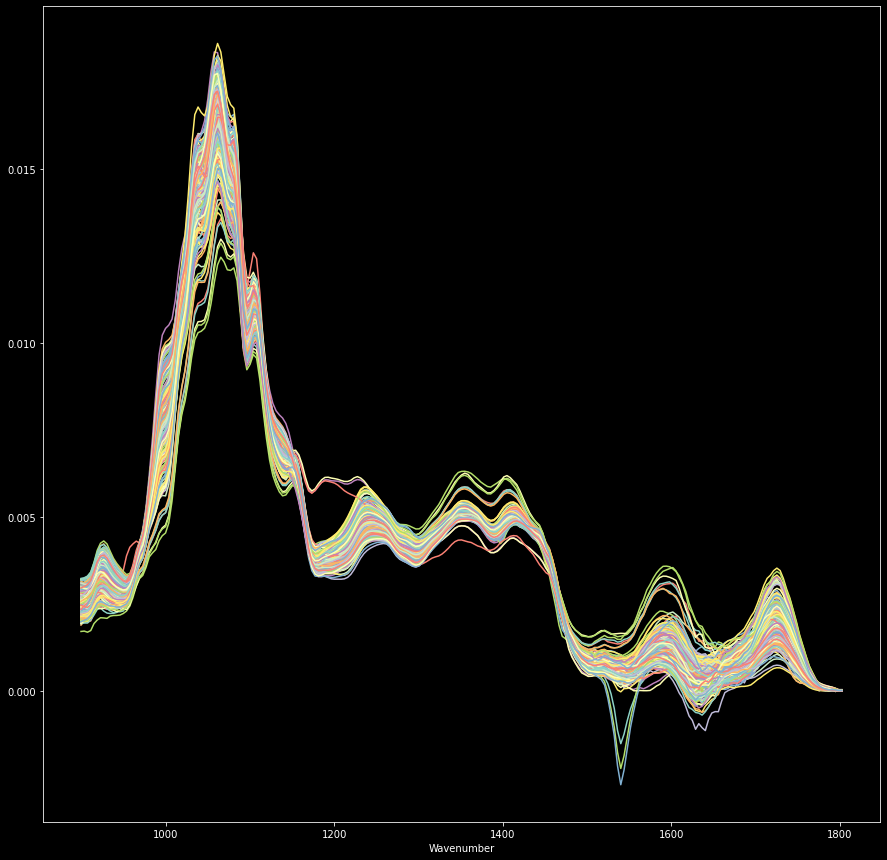

In [20]:
# plot wavenumber vs emission where Strawberry == True
plt.figure(figsize=(15,15))
plt.plot(dft.query('Outcome == True').loc[:,dft.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>

#### Plot the Training Set where Strawberry == False

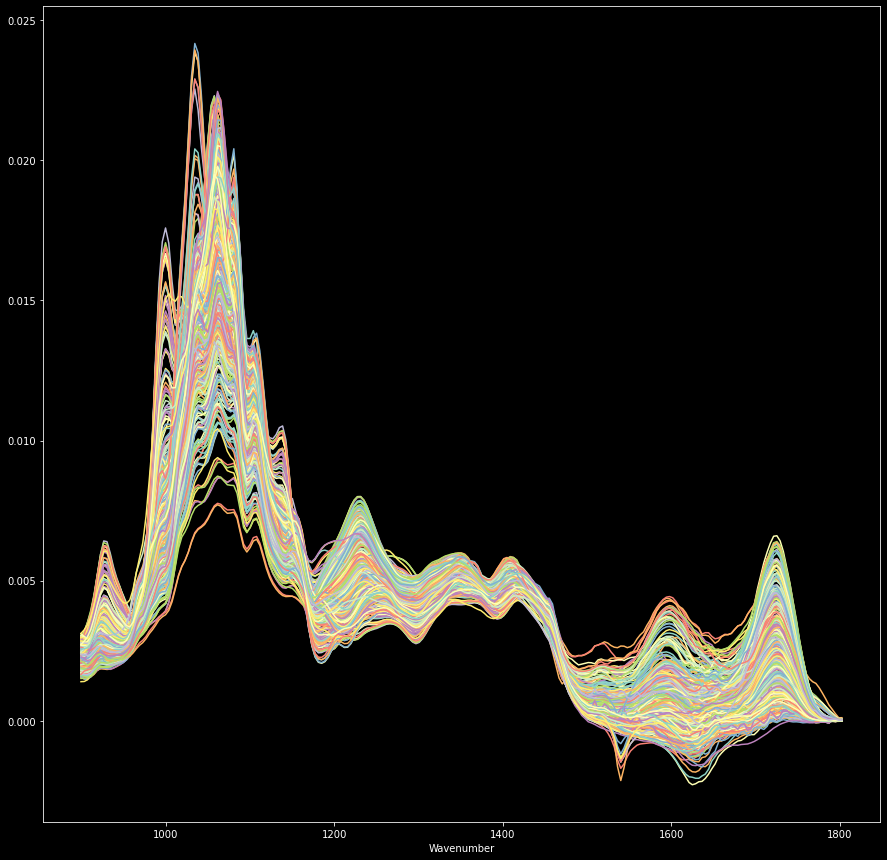

In [21]:
# plot the wavenumber vs emission where Strawberry == False
plt.figure(figsize=(15,15))
plt.plot(dft.query('Outcome == False').loc[:,dft.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>

#### Plot the Validation Set where Strawberry == True

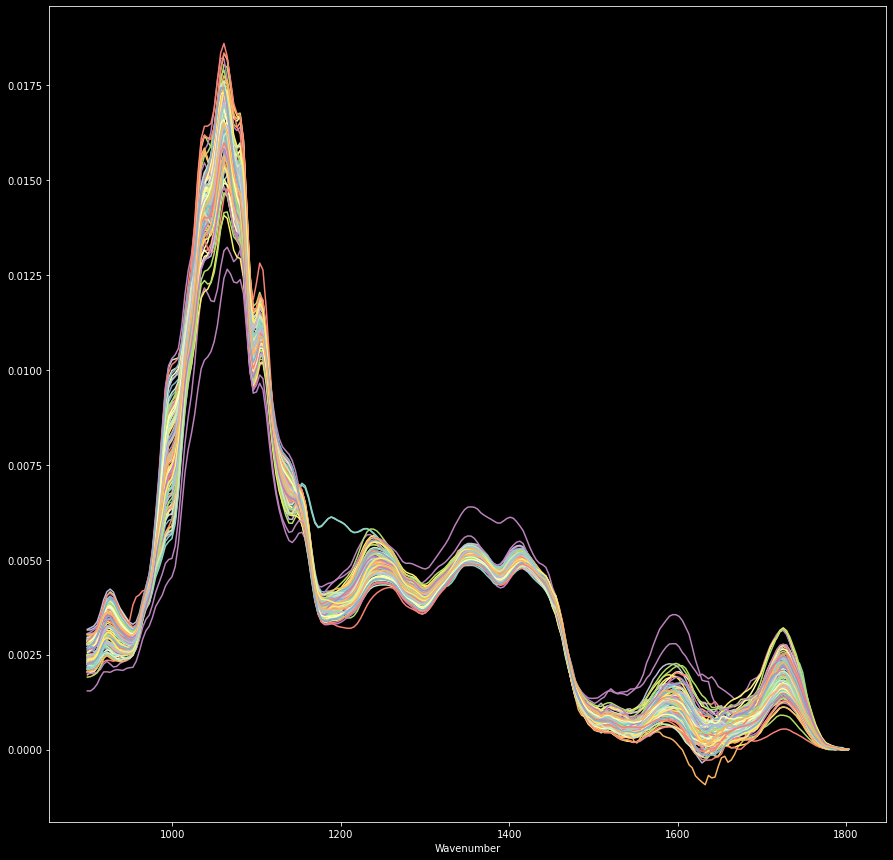

In [22]:
# plot wavenumber vs emission where Strawberry == True
plt.figure(figsize=(15,15))
plt.plot(dfv.query('Outcome == True').loc[:,dfv.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>

#### Plot the Validation Set where Strawberry == False

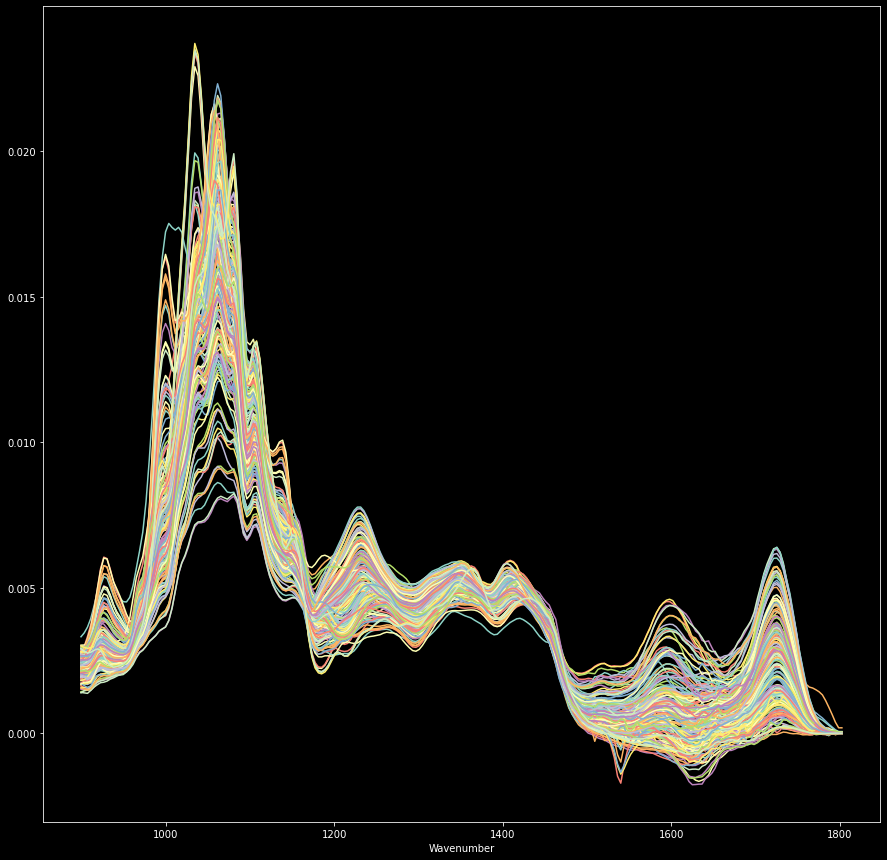

In [23]:
# plot the wavenumber vs emission where Strawberry == False
plt.figure(figsize=(15,15))
plt.plot(dfv.query('Outcome == False').loc[:,dfv.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>
<br>
<br>
<br>

# Analysis with FastAI

### Define the Learner

In [24]:
from fastai.tabular.all import *

# dls = TabularDataLoaders.from_df(dft, y_names=['Outcome'], procs = [Categorify, FillMissing, Normalize])
dls = TabularDataLoaders.from_df(dft, y_names=['Outcome'])

learn = tabular_learner(dls, lr=1e-3, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()], layers=[1000,10000,10000,1000]) #, layers=[1000,10000,10000,10000,1000])


<br>
<br>

### ~~Define an Early Callback~~

In [25]:
# early_stop = EarlyStoppingCallback(monitor='error_rate', min_delta=0.1, patience=2)

<br>
<br>

## Fit the model

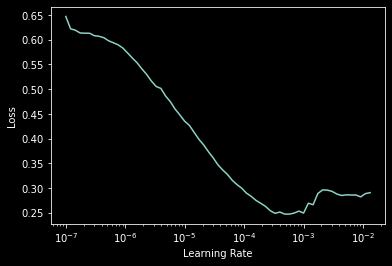

In [26]:
# plot the learning rates vs loss
lr_min,lr_steep = learn.lr_find()

In [27]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 5.75e-05, steepest point: 3.98e-06


In [28]:
learn.fit_one_cycle(35)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.250208,0.729664,0.635036,0.364964,0.534759,0.364964,1.000000,00:00
1,0.168781,0.715280,0.364964,0.635036,0.000000,0.000000,0.000000,00:00
2,0.135905,2.227194,0.635036,0.364964,0.534759,0.364964,1.000000,00:00
3,0.163169,3.670556,0.635036,0.364964,0.534759,0.364964,1.000000,00:00
4,0.230654,0.995738,0.364964,0.635036,0.000000,0.000000,0.000000,00:00
5,0.216450,2.562117,0.635036,0.364964,0.534759,0.364964,1.000000,00:00
6,0.186636,0.815971,0.627737,0.372263,0.522222,0.361538,0.940000,00:00
7,0.171902,3.403544,0.635036,0.364964,0.534759,0.364964,1.000000,00:00
8,0.160402,0.384188,0.072993,0.927007,0.895833,0.934783,0.860000,00:00
9,0.148012,0.812449,0.343066,0.656934,0.113208,1.000000,0.060000,00:00


/home/frank/miniconda3/envs/learn/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/frank/miniconda3/envs/learn/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# learn.fine_tune(4)

<br>
<br>

### Visualize the Training Set Results


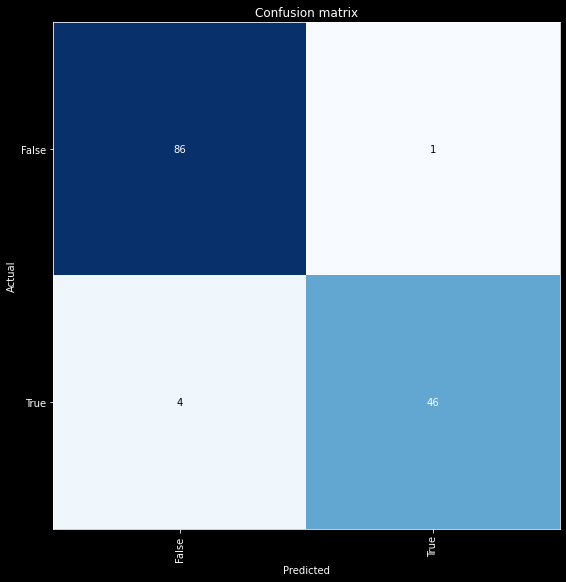

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

<br>
<br>
<br>

# Show Predictions

<br>

### Make a Random Prediction on an Item in the Validation Set

In [31]:
rown = 3
row = dfv.iloc[rown, :-1]

print(f'Actually a Strawberry:           {dfv.iloc[rown, -1]}')
print(f'Predicted to be a Strawberry:    { bool(learn.predict(row=row)[1]) }')
# print(f'Predicted to be a Strawberry:    { bool(learn.predict(row=row)[-1][1].item()) }')

Actually a Strawberry:           False


Predicted to be a Strawberry:    False


<br>
<br>
<br>

## Iteratively Predict Over the Entire Validation Set (Manually)

In [32]:
TP = 0
TN = 0
FP = 0
FN = 0

print('idx'.rjust(4) + '    ' + 'Actual'.ljust(6) + '   Predicted' )

for i in range(len(dfv)):
    actual = dfv.iloc[i, -1]
    predicted = bool(learn.predict(row=dfv.iloc[i, :-1])[1].item())
    
    print(f'{str(i).rjust(4)}    {str(actual).ljust(6)}   {predicted}')
    
    if (predicted == True):
        if (actual == True): TP += 1
        else: FP += 1
            
    if (predicted == False):
        if (actual == False): TN += 1
        else: FN += 1
        
print("\n")
print(f'True Positive={TP}')
print(f'True Negative={TN}')
print(f'False Positive={FP}')
print(f'False Negative={FN}');

 idx    Actual   Predicted


   0    False    False


   1    True     True


   2    False    False


   3    False    False


   4    True     True


   5    False    False


   6    True     True


   7    False    False


   8    False    False


   9    False    False


  10    False    False


  11    True     True


  12    True     True


  13    False    False


  14    True     True


  15    False    False


  16    False    False


  17    False    False


  18    True     True


  19    False    False


  20    False    False


  21    True     True


  22    False    False


  23    False    False


  24    False    False


  25    False    False


  26    False    False


  27    False    False


  28    True     True


  29    True     True


  30    False    False


  31    False    False


  32    False    False


  33    False    False


  34    True     False


  35    True     True


  36    True     True


  37    False    False


  38    False    False


  39    False    False


  40    True     True


  41    True     True


  42    False    False


  43    True     True


  44    False    False


  45    False    False


  46    True     False


  47    False    False


  48    True     True


  49    False    False


  50    True     True


  51    False    False


  52    False    False


  53    False    False


  54    True     True


  55    False    False


  56    False    False


  57    True     True


  58    False    False


  59    False    False


  60    True     True


  61    True     True


  62    True     True


  63    False    False


  64    True     True


  65    True     True


  66    True     True


  67    False    False


  68    False    False


  69    True     True


  70    False    False


  71    True     True


  72    False    False


  73    True     True


  74    False    False


  75    False    False


  76    True     True


  77    False    False


  78    False    False


  79    True     True


  80    False    False


  81    False    False


  82    False    False


  83    True     True


  84    True     True


  85    False    False


  86    False    False


  87    False    False


  88    False    False


  89    False    False


  90    False    False


  91    True     True


  92    True     True


  93    True     True


  94    False    False


  95    True     True


  96    True     True


  97    False    False


  98    False    False


  99    False    False


 100    True     True


 101    False    False


 102    True     True


 103    False    False


 104    True     True


 105    True     True


 106    False    False


 107    False    False


 108    True     True


 109    True     True


 110    True     True


 111    True     True


 112    True     True


 113    False    False


 114    False    False


 115    False    False


 116    False    False


 117    False    False


 118    False    False


 119    False    False


 120    True     True


 121    False    False


 122    False    False


 123    False    False


 124    False    False


 125    False    False


 126    False    False


 127    False    False


 128    True     True


 129    False    False


 130    True     True


 131    False    False


 132    False    False


 133    False    False


 134    True     True


 135    False    False


 136    False    False


 137    False    False


 138    False    False


 139    True     False


 140    False    False


 141    True     True


 142    True     True


 143    False    False


 144    False    False


 145    True     True


 146    False    False


 147    False    False


 148    True     True


 149    True     False


 150    False    False


 151    False    False


 152    False    False


 153    False    False


 154    False    False


 155    False    False


 156    False    False


 157    False    False


 158    False    False


 159    False    False


 160    True     True


 161    True     True


 162    False    False


 163    True     False


 164    False    False


 165    False    False


 166    True     True


 167    True     True


 168    False    False


 169    False    False


 170    False    False


 171    True     True


 172    False    False


 173    False    False


 174    False    False


 175    False    False


 176    True     True


 177    False    False


 178    False    False


 179    False    False


 180    True     True


 181    False    False


 182    False    False


 183    False    False


 184    False    False


 185    True     True


 186    False    False


 187    False    False


 188    False    False


 189    False    False


 190    False    False


 191    False    False


 192    True     True


 193    False    False


 194    False    False


 195    False    False


 196    False    False


 197    False    False


 198    True     True


 199    False    False


 200    True     True


 201    False    False


 202    False    False


 203    False    False


 204    False    False


 205    True     True


 206    False    False


 207    True     True


 208    True     True


 209    False    False


 210    False    False


 211    False    False


 212    False    False


 213    True     True


 214    False    False


 215    False    False


 216    True     True


 217    False    False


 218    False    False


 219    False    False


 220    False    False


 221    True     True


 222    True     True


 223    False    False


 224    False    False


 225    False    False


 226    True     True


 227    False    False


 228    True     True


 229    True     True


 230    False    False


 231    True     True


 232    True     True


 233    False    False


 234    False    False


 235    True     True


 236    True     True


 237    True     True


 238    False    False


 239    False    False


 240    False    False


 241    False    False


 242    False    False


 243    True     True


 244    False    False


 245    False    False


 246    True     True


 247    True     True


 248    True     True


 249    False    False


 250    False    False


 251    False    False


 252    True     True


 253    True     True


 254    True     True


 255    False    False


 256    True     True


 257    False    False


 258    False    False


 259    False    False


 260    True     True


 261    False    False


 262    True     True


 263    False    False


 264    True     True


 265    False    False


 266    True     True


 267    False    False


 268    True     True


 269    False    False


 270    True     True


 271    False    False


 272    False    False


 273    False    False


 274    False    False


 275    False    False


 276    True     True


 277    False    False


 278    True     True


 279    False    False


 280    False    False


 281    True     True


 282    False    False


 283    False    False


 284    True     True


 285    False    False


 286    False    False


 287    False    False


 288    True     True


 289    False    False


 290    True     True


 291    True     True


 292    False    False


 293    False    False


 294    False    False


True Positive=101
True Negative=189
False Positive=0
False Negative=5


<br>
<br>
<br>

# Score the Predictions (FastAI Version)

In [33]:
accuracy = (TP + TN) / len(dfv)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = (2 * precision * recall) / (precision + recall)

print('\nFastAI Predictions: \n')
print(f'Accuracy:    {round(accuracy,4)}')
print(f'Precision:   {round(precision,4)}')
print(f'Recall:      {round(recall,4)}')
print(f'F1 Score:    {round(F1,4)}')


FastAI Predictions: 

Accuracy:    0.9831
Precision:   1.0
Recall:      0.9528
F1 Score:    0.9758


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Let's Play with Tensorflow/Keras!

Here we implement a simple backprop network using Keras.

In [34]:
from sklearn.model_selection import train_test_split
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight



In [35]:
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.25)
dft_orig = dft.copy().astype('float32')
dfv_orig = dfv.copy().astype('float32')
# dft = dft_orig.copy().astype('float32')
# dfv = dfv_orig.copy().astype('float32')
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
dft = scaler_x.fit_transform(dft)
dfv = scaler_y.fit_transform(dfv)
dft = pd.DataFrame(dft, columns=dft_orig.columns)
dfv = pd.DataFrame(dfv, columns=dfv_orig.columns)


In [36]:
dft

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
0,0.981347,0.960412,0.824567,0.691549,0.607546,0.523327,0.449541,0.406167,0.395328,0.392187,...,0.213841,0.170347,0.163896,0.163894,0.239904,0.110505,0.074909,0.128560,0.128560,1.0
1,0.843330,0.837760,0.743351,0.658910,0.599136,0.531902,0.469937,0.421849,0.399537,0.396379,...,0.126499,0.100316,0.088248,0.090229,0.158502,0.082903,0.128238,0.154491,0.154491,1.0
2,0.533127,0.526459,0.462838,0.415048,0.394314,0.348799,0.310898,0.275631,0.260818,0.264373,...,0.147289,0.107370,0.084475,0.085579,0.152473,0.076654,0.121770,0.116315,0.116315,1.0
3,0.730834,0.871431,0.909312,0.909255,0.927089,0.949740,0.964508,0.961156,0.958184,0.955477,...,0.075891,0.059147,0.045131,0.049453,0.112611,0.022527,0.079925,0.111823,0.111823,0.0
4,0.502416,0.514021,0.445597,0.372750,0.331240,0.289092,0.262319,0.246302,0.245863,0.254553,...,0.328683,0.253039,0.227074,0.209125,0.264813,0.149228,0.144387,0.200988,0.200988,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,0.530662,0.576455,0.558463,0.506580,0.496774,0.490147,0.469925,0.452010,0.446186,0.447602,...,0.195985,0.145789,0.116439,0.106604,0.168047,0.101261,0.143144,0.159535,0.159535,0.0
684,0.634268,0.633132,0.553238,0.497677,0.486694,0.453787,0.403525,0.360148,0.342164,0.340854,...,0.075158,0.063270,0.034041,0.038982,0.094289,0.052337,0.158557,0.145340,0.145340,0.0
685,0.726945,0.776597,0.745623,0.712831,0.699307,0.677967,0.656951,0.636865,0.625115,0.623432,...,0.078276,0.063493,0.054653,0.061663,0.128293,0.052071,0.118753,0.150609,0.109501,0.0
686,0.533618,0.526413,0.421088,0.338659,0.301498,0.246588,0.198176,0.163173,0.146810,0.145968,...,0.301179,0.234475,0.162691,0.147752,0.169072,0.170384,0.319745,0.279286,0.279286,0.0


In [37]:
dfv

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
0,0.710167,0.705175,0.711414,0.703294,0.695765,0.679834,0.647414,0.632145,0.626070,0.621693,...,0.068340,0.050367,0.051310,0.056778,0.102830,0.030793,0.121428,0.054929,0.054929,0.0
1,0.643819,0.640622,0.628800,0.601937,0.590710,0.579166,0.534092,0.499388,0.483702,0.480175,...,0.141006,0.099775,0.081660,0.077681,0.113543,0.046596,0.151878,0.082290,0.082290,1.0
2,0.687106,0.604660,0.519923,0.425919,0.358778,0.295487,0.201990,0.138558,0.100862,0.065433,...,0.081609,0.054696,0.050190,0.050468,0.084111,0.015360,0.126752,0.065041,0.053029,0.0
3,0.674837,0.621429,0.595248,0.574077,0.551349,0.524064,0.462225,0.415693,0.393708,0.379490,...,0.217601,0.152354,0.044011,0.045612,0.033768,0.092540,0.352696,0.139058,0.139058,0.0
4,0.525917,0.489487,0.455828,0.424299,0.413998,0.391879,0.339874,0.300651,0.286694,0.276683,...,0.129032,0.087409,0.074200,0.069191,0.103012,0.038263,0.142968,0.081378,0.081378,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,0.666746,0.653988,0.644239,0.621743,0.613213,0.597218,0.548071,0.515705,0.502084,0.494795,...,0.125939,0.088895,0.071560,0.070260,0.108830,0.040347,0.143027,0.067544,0.067544,1.0
291,0.854961,0.794369,0.734833,0.669561,0.626895,0.573622,0.482915,0.427554,0.408745,0.396037,...,0.130049,0.092842,0.088911,0.089077,0.132837,0.049165,0.128478,0.080374,0.080374,1.0
292,0.386714,0.369025,0.328530,0.274058,0.243440,0.224950,0.182648,0.143738,0.121872,0.113661,...,0.257484,0.202671,0.147133,0.143407,0.155420,0.158268,0.332568,0.219357,0.219357,0.0
293,0.589872,0.546217,0.504618,0.453201,0.422840,0.391205,0.332272,0.293786,0.272867,0.263481,...,0.250717,0.173055,0.136163,0.117690,0.142471,0.077447,0.170879,0.081048,0.081048,0.0


In [38]:

model = Sequential()
model.add(Dense(1000, input_dim=235, activation='relu'))
model.add(Dense(10000, activation='relu'))
# model.add(Dense(10000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              236000    
_________________________________________________________________
dense_1 (Dense)              (None, 10000)             10010000  
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              10001000  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1001      
Total params: 20,248,001
Trainable params: 20,248,001
Non-trainable params: 0
_________________________________________________________________


In [39]:
# model.compile(optimizer='adam', loss='mean_squared_error')
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# weights = class_weight.compute_class_weight(class_weight='balanced',
#                                             classes=np.unique(dft.iloc[:,-1]),
#                                             y=dft.iloc[:,-1])
# weights

In [40]:
epochs_hist = model.fit(dft.iloc[:,:-1].values, dft.iloc[:,-1], epochs=100, batch_size=24,  verbose=1, validation_split=0.25)


Epoch 1/100
22/22 [==============================] - 1s 22ms/step - loss: 2.5996 - accuracy: 0.5782 - val_loss: 0.3668 - val_accuracy: 0.8605
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 0.7441 - accuracy: 0.6599 - val_loss: 0.5711 - val_accuracy: 0.7442
Epoch 3/100
22/22 [==============================] - 0s 8ms/step - loss: 0.5458 - accuracy: 0.6543 - val_loss: 0.7949 - val_accuracy: 0.5756
Epoch 4/100
22/22 [==============================] - 0s 8ms/step - loss: 0.6331 - accuracy: 0.6563 - val_loss: 0.4321 - val_accuracy: 0.7558
Epoch 5/100
22/22 [==============================] - 0s 8ms/step - loss: 0.5452 - accuracy: 0.7493 - val_loss: 0.3969 - val_accuracy: 0.8140
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 0.5068 - accuracy: 0.7372 - val_loss: 0.4239 - val_accuracy: 0.7849
Epoch 7/100
22/22 [==============================] - 0s 8ms/step - loss: 0.4540 - accuracy: 0.7758 - val_loss: 0.3236 - val_accuracy: 0.8314
Epoch 8/100


In [41]:
print(epochs_hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


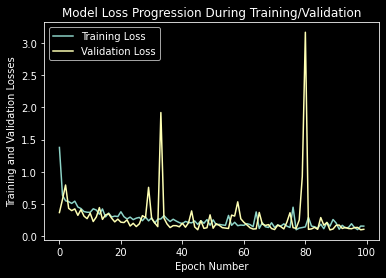

In [42]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])

plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Training and Validation Losses')
plt.xlabel('Epoch Number')
plt.legend(['Training Loss', 'Validation Loss'])

In [43]:
TP = 0
TN = 0
FP = 0
FN = 0

print('idx'.rjust(4) + '    ' + 'Actual'.ljust(6) + '   Predicted' )

for i in range(len(dfv)):
    actual = bool(dfv.iloc[i, -1])
    predicted = bool(np.round(model.predict(dfv.iloc[i, :-1].values.reshape((1,235))), decimals=0))
    
    print(f'{str(i).rjust(4)}    {str(actual).ljust(6)}   {predicted}')
    
    if (predicted == True):
        if (actual == True): TP += 1
        else: FP += 1
            
    if (predicted == False):
        if (actual == False): TN += 1
        else: FN += 1
        
print("\n")
print(f'True Positive={TP}')
print(f'True Negative={TN}')
print(f'False Positive={FP}')
print(f'False Negative={FN}');

 idx    Actual   Predicted
   0    False    False
   1    True     True
   2    False    False
   3    False    False
   4    True     True
   5    False    False
   6    True     True
   7    False    False
   8    False    False
   9    False    False
  10    False    False
  11    True     True
  12    True     True
  13    False    False
  14    True     True
  15    False    False
  16    False    False
  17    False    False
  18    True     True
  19    False    False
  20    False    False
  21    True     True
  22    False    False
  23    False    False
  24    False    False
  25    False    False
  26    False    False
  27    False    False
  28    True     True
  29    True     True
  30    False    False
  31    False    False
  32    False    True
  33    False    False
  34    True     False
  35    True     True
  36    True     True
  37    False    False
  38    False    False
  39    False    False
  40    True     True
  41    True     True
  42    False    False

<br>
<br>
<br>

# Score the Predictions (TensorFlow Version)

In [44]:
accuracy = (TP + TN) / len(dfv)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = (2 * precision * recall) / (precision + recall)

print('\nTensorflow Predictions: \n')
print(f'Accuracy:    {round(accuracy,4)}')
print(f'Precision:   {round(precision,4)}')
print(f'Recall:      {round(recall,4)}')
print(f'F1 Score:    {round(F1,4)}')


Tensorflow Predictions: 

Accuracy:    0.9559
Precision:   0.9697
Recall:      0.9057
F1 Score:    0.9366


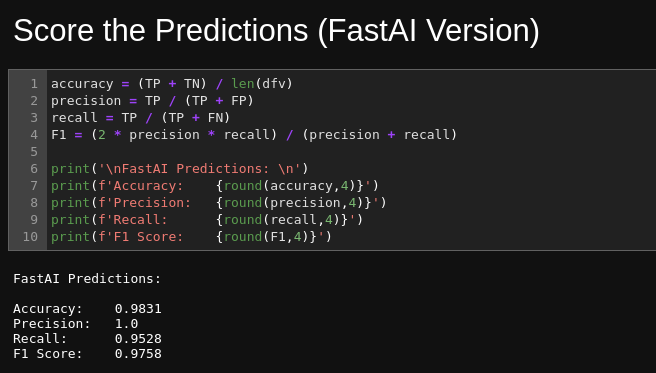

This is a screenshot from the previous analysis with FastAI (earlier in this notebook)